In [69]:
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, resample, periodogram
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

tqdm.pandas()

In [ ]:
## Read data

In [2]:
PATH_DATA="DATA/IN.txt"
df=pd.read_csv(PATH_DATA,delimiter="\t",header=None,names=["id","event","device","channel","code","size","data"])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65250 entries, 0 to 65249
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       65250 non-null  int64 
 1   event    65250 non-null  int64 
 2   device   65250 non-null  object
 3   channel  65250 non-null  object
 4   code     65250 non-null  int64 
 5   size     65250 non-null  int64 
 6   data     65250 non-null  object
dtypes: int64(4), object(3)
memory usage: 3.5+ MB
None


,id,event,device,channel,code,size,data
0,1142043,173652,IN,AF3,0,256,"4259.487179,4237.948717,4247.179487,4242.05128..."
1,1142044,173652,IN,AF4,0,256,"4103.076923,4100.512820,4102.564102,4087.69230..."
2,1142045,173652,IN,T7,0,256,"4245.128205,4218.461538,4242.051282,4245.12820..."
3,1142046,173652,IN,T8,0,256,"4208.717948,4188.717948,4204.102564,4198.46153..."
4,1142047,173652,IN,PZ,0,256,"4189.230769,4203.589743,4188.717948,4186.66666..."


In [6]:
N_CHANNELS = df.channel.nunique()

In [3]:
df.data=df.data.progress_apply(lambda x: [float(i) for i in x.split(",")])

In [4]:
# Resample

def get_values_df(df_aux,resample_value=256):
    df_aux=df_aux.sort_values(by="channel")
    channels_values=pd.DataFrame(dict(zip(df_aux["channel"],df_aux["data"]))).values.T.reshape(5,-1)
    channels_values=resample(channels_values,resample_value,axis=1)
    label=df_aux.code.iloc[0]
    return pd.Series({'eeg': channels_values, 'label': label}) #https://stackoverflow.com/questions/10751127/returning-multiple-values-from-pandas-apply-on-a-dataframe

df_preprocessed=df.groupby(['event']).progress_apply(lambda row: get_values_df(row)).reset_index()

In [18]:
## Train test split
ids_train, ids_test, y_train, y_test=train_test_split(df_preprocessed.index,df_preprocessed.label,test_size=0.2,random_state=11)

df_train=df_preprocessed.loc[ids_train].reset_index(drop=True)
df_test=df_preprocessed.loc[ids_test].reset_index(drop=True)

In [7]:
N_CHANNELS

5

In [19]:
df_train.iloc[0].eeg.shape

(5, 256)

In [30]:
df_train.eeg.values.shape

(10440,)

In [52]:
# Standarization
NORM_BY = "channel" # "all"

if NORM_BY=="channel":
    scalers=dict(zip(list(range(N_CHANNELS)),[StandardScaler() for x in range(N_CHANNELS)]))

    # Fitting the scalers
    for i in range(N_CHANNELS):
        scalers[i].fit(np.asarray([x[i] for x in df_train.eeg.values]))

    # Standarization of the data
    for i in tqdm(range(N_CHANNELS)): 
        df_train[f"channel_{i}"]=list(scalers[i].transform([x[i] for x in df_train.eeg.values]))
    
    for i in tqdm(range(N_CHANNELS)):
        df_test[f"channel_{i}"]=list(scalers[i].transform([x[i] for x in df_test.eeg.values]))

df_train.head()

,event,eeg,label,channel_0,channel_1,channel_2,channel_3,channel_4
0,180187,"[[4277.948716999999, 4283.076923000001, 4276.9...",4,"[-0.4089923219851625, -0.2862057300676179, -0....","[0.04114473344744017, -0.154329455598954, -0.2...","[0.3062747623582641, 0.4378076810266323, 0.419...","[0.1863917340224224, 0.33277562394364063, 0.15...","[0.4088384260938193, -0.13996454068586714, -0...."
1,180942,"[[4230.256410000001, 4240.682899890823, 4231.6...",3,"[-1.4405427928577532, -1.165159712780104, -1.4...","[-1.2044239480725039, -1.000296413978728, -1.2...","[-0.9082877774632108, -0.6358048233905929, -0....","[-0.5750865363188178, -0.37494135682037233, -0...","[-1.2428119006569365, -0.34545070323173344, -0..."
2,184457,"[[4278.461537999998, 4282.051281999999, 4283.0...",6,"[-0.39790037073982304, -0.30747031350815013, -...","[0.38284941789049387, 0.4404137074988624, 0.53...","[0.41008352385031177, 0.5827052362976647, 0.79...","[-0.29392531861612536, -0.07019730055196173, 0...","[0.4570617922686661, 0.4088024529963619, 0.318..."
3,183185,"[[4408.7179479999995, 4412.344190443196, 4386....",8,"[2.419452563553741, 2.393888566738031, 1.96582...","[0.0631901962665517, -0.1085569932780141, -0.3...","[-0.3788630837322571, -0.4864173287364819, -0....","[-0.047909261692952024, -0.19839511426369227, ...","[-1.2789794370425693, -1.3291952455374634, -1...."
4,180542,"[[4316.923076, 4316.410256, 4302.564102000001,...",2,"[0.43399517237969326, 0.40489324211479016, 0.1...","[0.08523565908562414, 0.34128983982363786, 0.1...","[0.731890694597115, 0.7276027713866248, 0.5752...","[-0.2587801806810031, 0.0193522382248035, 0.31...","[-0.04928355256691504, 0.575818494551834, 0.91..."


In [75]:
# Filtering

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

df_train_filtered=df_train.copy()
df_test_filtered=df_test.copy()

fs = 256/2

for i in tqdm(range(N_CHANNELS)): 
    df_train_filtered[f"channel_{i}"]=df_train_filtered[f"channel_{i}"].progress_apply(butter_bandpass_filter, args=(2,40,fs,10,))

for i in tqdm(range(N_CHANNELS)): 
    df_test_filtered[f"channel_{i}"]=df_test_filtered[f"channel_{i}"].progress_apply(butter_bandpass_filter, args=(2,40,fs,10,))

<AxesSubplot:>

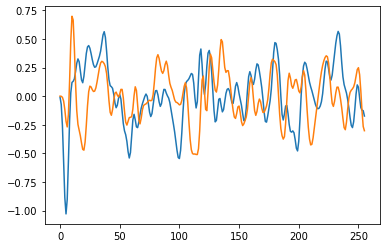

In [76]:
sns.lineplot(x=list(range(len(df_train.iloc[1].channel_0))),y=df_train.iloc[1].channel_0)
sns.lineplot(x=list(range(len(df_train_filtered.iloc[1].channel_0))),y=df_train_filtered.iloc[1].channel_0)

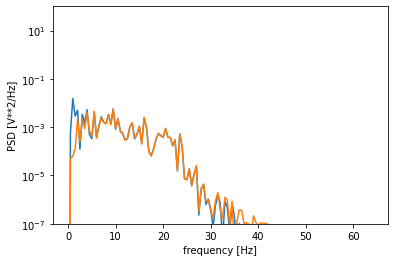

In [78]:
f, Pxx_den = periodogram(df_train.iloc[0].channel_0,fs)
plt.semilogy(f, Pxx_den)
f, Pxx_den = periodogram(df_train_filtered.iloc[0].channel_0,fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

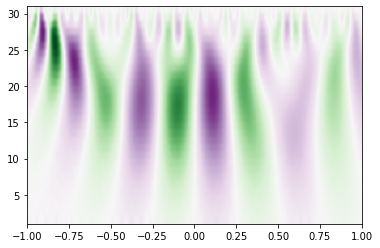

In [83]:
import pywt

t = list(np.arange(0,2,1/256))
sig  = df_train_filtered.iloc[3].channel_0
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
plt.show() # doctest: +SKIP

In [87]:
cwtmatr

array([[-0.00671901, -0.0252071 , -0.06363263, ..., -0.04204345,
        -0.05957867, -0.02318748],
       [-0.11255611, -0.17995985, -0.19717178, ..., -0.15407221,
        -0.09866699, -0.00174348],
       [-0.17063231, -0.0842883 ,  0.13144861, ..., -0.36213067,
        -0.19923771, -0.03669297],
       ...,
       [ 0.02149617,  0.01522874, -0.00037999, ...,  0.07102535,
         0.05067174,  0.03436683],
       [ 0.0151388 ,  0.01070365, -0.00501751, ...,  0.07977151,
         0.06069989,  0.0332459 ],
       [-0.02829046, -0.00264232,  0.02553659, ...,  0.0542726 ,
         0.05227237,  0.05023724]])